# Example of synapse and acquisition

In [26]:
import numpy 
import os

from matplotlib import pyplot
from skimage import io

from gym_sted import rewards, defaults
from gym_sted.rewards import objectives
from gym_sted.utils import SynapseGenerator, MicroscopeGenerator, get_foreground, BleachSampler, Normalizer

obj_dict = {
    "SNR" : objectives.Signal_Ratio(75),
    "Bleach" : objectives.Bleach(),
    "Resolution" : objectives.Resolution(pixelsize=20e-9),
    "Squirrel" : objectives.Squirrel(),
    "NbNanodomains" : objectives.NumberNanodomains()
}
bounds_dict = {
    "SNR" : {"low" : 0.20, "high" : numpy.inf},
    "Bleach" : {"low" : -numpy.inf, "high" : 0.5},
    "Resolution" : {"low" : 0, "high" : 100},
    "NbNanodomains" : {"low" : 0, "high" : numpy.inf}
}
scales_dict = {
    "SNR" : {"low" : 0, "high" : 1},
    "Bleach" : {"low" : 0, "high" : 1},
    "Resolution" : {"low" : 40, "high" : 180},
    "NbNanodomains" : {"low" : 0, "high" : 1}
}


In [39]:
actions = ["p_sted", "p_ex", "pdt"]
action = [30.0e-3, 15.0e-6, 15.0e-6]

molecules = 5
seed = 42# seeds 10, 42
synapse_generator = SynapseGenerator(
    mode="mushroom", seed=seed, n_nanodomains=(3, 15), n_molecs_in_domain=(molecules * 20, molecules * 35)
)
microscope_generator = MicroscopeGenerator()
microscope = microscope_generator.generate_microscope()

synapse = synapse_generator(rotate=False)
datamap = microscope_generator.generate_datamap(
    datamap = {
        "whole_datamap" : synapse.frame,
        "datamap_pixelsize" : microscope_generator.pixelsize
    }
)

# Generates imaging parameters
sted_params = microscope_generator.generate_params(
    imaging = {
        name : action[actions.index(name)]
            if name in actions else getattr(defaults, name.upper())
            for name in ["pdt", "p_ex", "p_sted"]
    }
)
conf_params = microscope_generator.generate_params()

# Acquire confocal image
conf1, bleached, _ = microscope.get_signal_and_bleach(
    datamap, datamap.pixelsize, **conf_params, bleach=False
)

# Acquire STED image
sted_image, bleached, _ = microscope.get_signal_and_bleach(
    datamap, datamap.pixelsize, **sted_params, bleach=True
)

# Acquire confocal image
conf2, bleached, _ = microscope.get_signal_and_bleach(
    datamap, datamap.pixelsize, **conf_params, bleach=False
)

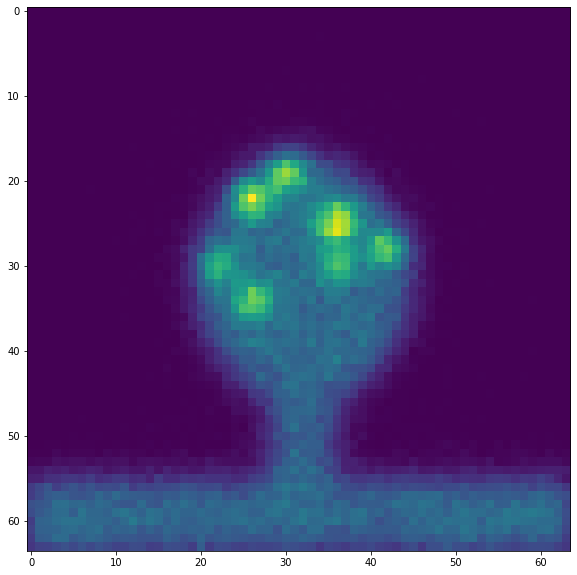

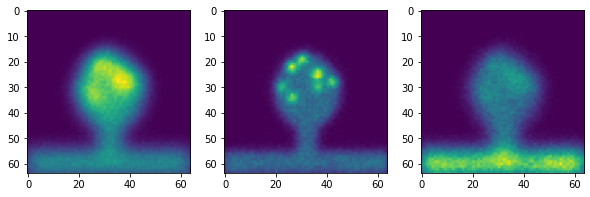

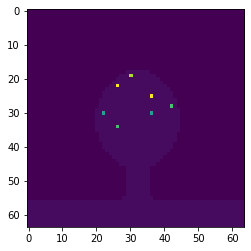

In [40]:
fig, ax = pyplot.subplots(figsize=(10, 10))
ax.imshow(sted_image)
pyplot.show()

fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(conf1)
axes[1].imshow(sted_image, vmin=0, vmax=sted_image.max())
# axes[1].scatter(numpy.array(synapse.nanodomains_coords)[:, 1],numpy.array(synapse.nanodomains_coords)[:, 0], color="black", marker="x", cmap="hot")
axes[2].imshow(conf2)
pyplot.show()

fig, ax = pyplot.subplots()
ax.imshow(synapse.frame)
pyplot.show()
# print(dir(synapse))

In [41]:
io.imsave(os.path.join("panels", f"conf1-{seed}.tif"), conf1.astype(numpy.uint16), check_contrast=False)
io.imsave(os.path.join("panels", f"sted-{seed}.tif"), sted_image.astype(numpy.uint16), check_contrast=False)
io.imsave(os.path.join("panels", f"conf2-{seed}.tif"), conf2.astype(numpy.uint16), check_contrast=False)
io.imsave(os.path.join("panels", f"datamap-{seed}.tif"), synapse.frame.astype(numpy.uint16), check_contrast=False)

# Example of expert demonstrations

In [42]:
import pickle
import os
import bz2

from skimage import io

with bz2.open("/home/anthony/Documents/gym-sted/gym_sted/prefnet/demonstrations/demonstrations.pbz2", "rb") as file:
    all_infos = pickle.load(file)

for i, infos in enumerate(all_infos[:1]):
    images = {key : [] for key in ["conf1", "sted_image", "conf2"]}
    for info in infos:
        for key in images.keys():
            images[key].append(info[key])
    
#     fig, axes = pyplot.subplots(3, 1, figsize=(15,5), sharex=True, sharey=True)
    for ax, (key, values) in zip(axes.ravel(), images.items()):
        values = numpy.concatenate(values, axis=-1)
#         ax.imshow(values, cmap="hot", vmin=0)
#     pyplot.show()
    key = "sted_image"
    values = numpy.concatenate(images[key], axis=-1).astype(numpy.uint16)
    io.imsave(os.path.join("panels", f"expert-{key}.tif"), values.astype(numpy.uint16), check_contrast=False)

# Temporal datamap

In [25]:
import pysted 

from tqdm.auto import tqdm

actions = ["p_sted", "p_ex", "pdt"]
action = [30.0e-3, 15.0e-6, 15.0e-6]

molecules = 5
synapse_generator = SynapseGenerator(
    mode="mushroom", seed=10, n_nanodomains=(3, 15), n_molecs_in_domain=0
)
synapse = synapse_generator.generate(rotate=False)

temporal_datamap = microscope_generator.generate_temporal_datamap_smoother_flash(
    temporal_datamap={
        "whole_datamap": synapse.frame,
        "datamap_pixelsize": microscope_generator.pixelsize,
        "synapse_obj": synapse
    },
    decay_time_us=2000000,
    n_decay_steps=20,
    flash_delay=(2, 8),
    individual_flashes=True
)

# clock = pysted.base.Clock(1)
# temporal_experiment = pysted.base.TemporalExperiment(clock, microscope, temporal_datamap,
#                                                           2000000, bleach=False,
#                                                           bleach_mode="proportional")

# # Generates imaging parameters
# sted_params = microscope_generator.generate_params(
#     imaging = {
#         name : action[actions.index(name)]
#             if name in actions else getattr(defaults, name.upper())
#             for name in ["pdt", "p_ex", "p_sted"]
#     }
# )
# conf_params = microscope_generator.generate_params()

# normalized_time = temporal_experiment.clock.current_time / temporal_experiment.exp_runtime
# while normalized_time <= 1:
#     sted_image, bleached = temporal_experiment.play_action(**sted_params)
#     normalized_time = temporal_experiment.clock.current_time / temporal_experiment.exp_runtime
#     print(normalized_time)
#     fig, ax = pyplot.subplots()
#     ax.imshow(sted_image)
#     pyplot.show()
# print(sted_image)

frame = temporal_datamap.whole_datamap[temporal_datamap.roi]
flashes = temporal_datamap.flash_tstack[:, temporal_datamap.roi[0], temporal_datamap.roi[1]] + frame

conf1_images = []
for frame in tqdm(flashes):
    datamap = microscope_generator.generate_datamap(
        datamap = {
            "whole_datamap" : frame,
            "datamap_pixelsize" : microscope_generator.pixelsize
        }
    )
    # Acquire STED image
    conf1, bleached, _ = microscope.get_signal_and_bleach(
        datamap, datamap.pixelsize, **conf_params, bleach=False
    )
    
    conf1_images.append(conf1)
conf1_images = numpy.array(conf1_images)

io.imsave(os.path.join("panels", f"temporal-stack.tif"), conf1_images.astype(numpy.uint16), check_contrast=False)

  0%|          | 0/24 [00:00<?, ?it/s]